<a href="https://colab.research.google.com/github/ifaul/ifaul.github.io/blob/main/lang_acquire_milestone2_11_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ian Faul, Matthew Vuong

**ESL to ETL: Investigating English proficiency of 2/3 million speakers**

[Link to our website](https://ifaul.github.io/)

[Link to CSV file in Drive](https://drive.google.com/file/d/1LJg6wTE_rl3WXP5lOFRoCuatc1WZjEQm/view?usp=share_link)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re

pd.options.mode.copy_on_write = True

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ColabNotebooks

Mounted at /content/drive
/content/drive/MyDrive/ColabNotebooks


In [3]:
#%%shell
#jupyter nbconvert --to html /content/drive/MyDrive/ColabNotebooks/lang_acquire_milestone1.ipynb

# **Project Goals**

How humans acquire new languages, and why some people are better at it than others, remains a remarkably mysterious question. While it is well-known that children are the most efficient language learners and that language-learning ability declines with age, the specific factors contributing to learning ability (age, gender, country of origin, native language, age at start of second language acquisition, etc.) are more complicated. Here, we plan on using a large dataset of close to 650,000 individuals to disentangle some of these factors and, hopefully, create a model that uses them to estimate language learning trajectory for English. In particular, we are curious to see whether there are any patterns in performance on particular questions across various groups, which would reveal both the underlying linguistic features being tested and those that are compartively more difficult to acquire. This was something not examined by the study associated with this dataset (Hartshorne, J.K. et al, 2018); while our intention isn't to directly replicate their findings, our secondary goal is to determine whether our results converge with their conclusions.

**Collaboration plan**

We (Ian Faul and Matthew Vuong) plan on meeting weekly to discuss the project's direction and implementation, assisting each other when necessary. We will also regularly update a document tracking which steps need to be completed and who they are to be completed by to ensure that work is fairly distributed. Lastly, we will establish a shared Github respository to store our code and our updates to it, allowing us to work remotely.

# **Milestone 1**
### **Some ETL**

We came across this dataset in the "Data Is Plural" archive and downloaded it from [OSF](https://osf.io/pyb8s/wiki/home/). We considered several similar datasets for this project, but this one stood out due to the large number of variables and observations, as well as its being associated with a study whose conclusions we could build on. The original dataset included the following variables:

**id** Unique subject ID

**date** Date at start of experiment

**time** Time at start of experiment

**gender**

**age**

**natlangs** List of subject's native languages

**primelangs** List of subject's primary language now

**dyslexia** Did subject report difficulty with reading?

**psychiatric** Did subject report any psychiatric disorders

**education** highest level of education

**Eng_start** age at start of English learning

**Eng_country_yrs** number of years living in English-speaking country

**house_Eng** subject lives with any native English speakers?

**dictionary** subject reported using a dictionary to complete experiment

**already_participated** Subject reported prior participation in experiment

**countries** countries lived in

**currcountry** country currently lived in

**US_region** regions of USA lived in

**UK_region** regions of UK lived in

**Can_region** regions of Canada lived in

**Ebonics** speaker of Ebonics?

**Ir_region** county of Ireland lived in

**UK_constituency** constituency of UK lived in

**nat_Eng** native speaker of English

**lived_Eng_per** Percentage of years speaking English that lived in English-speaking country.

**Eng_little** values are monoeng (native speaker of English only), bileng (native speaker of English + at least one other lang), lot (immersion learner), little (non-immersion learner).

**q1, q2, etc.** test questions, with subparts

**correct** percentage of critical items correct

**elogit** elogit of correct (not sure what this means)


While this data was originally collected for the primary purpose of finding the critical point in development where grammar-learning ability begins to decline (their finding: 17.4 years), some other specific questions this dataset allows us to consider are (1) Can the test questions be grouped into distinct types, other than the syntactic phenomena explicity included by the original researchers, based on systematic differences in performance among groups? (2) Are there systematic differences in the performance of speakers of native languages other than English? In other words, in which ways do speakers of some languages (or language groups) perform better or worse than others? (3) For people at or above the critical age found in the original study, which variables are associated with the highest overall performance or performance on specific questions/question types?

In the following section, we consider a more workable subset of 10,000 observations, removing variables likely of little relevance, creating new columns to more easily access information separated by commas in individual cells in the original data table, making values within columns consistent and of the correct data type, and lastly, tidying it up.

In [4]:
df_lang = pd.read_csv('data.csv', nrows=100001)
df_lang.head()

<ipython-input-4-a1f1fb77e63c>:1: DtypeWarning: Columns (22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_lang = pd.read_csv('data.csv', nrows=100001)


,Unnamed: 0,id,date,time,gender,age,natlangs,primelangs,dyslexia,psychiatric,...,q34_6,q34_8,q35_1,q35_2,q35_4,q35_5,q35_7,q35_8,correct,elogit
0,1,2.0,2014-05-29,01:00:55,male,31,English,English,0,0,...,1,1,1,1,1,1,1,1,0.978947,3.621671
1,2,3.0,2014-05-29,01:01:03,male,30,English,English,0,1,...,1,1,1,1,1,1,1,1,1.000000,5.252273
2,3,3.0,2014-05-29,01:01:03,male,30,English,English,0,1,...,1,1,1,1,1,1,1,1,1.000000,5.252273
3,4,4.0,2014-05-29,01:01:13,male,19,English,English,0,0,...,1,1,1,1,1,0,1,1,0.905263,2.208853
4,5,5.0,2014-05-29,01:01:19,male,20,"Chinese/Mandarin, English","Chinese/Mandarin, English",0,0,...,1,1,1,1,1,0,1,1,0.947368,2.800602


In [5]:
# Remove unnecessary variables

df_lang.drop(columns=['Unnamed: 0', 'date', 'time', 'US_region', 'UK_region',
                      'Can_region', 'Ir_region', 'UK_constituency', 'tests'], inplace=True)

# Strip whitespace in all columns

df_lang = df_lang.map(lambda x: x.strip() if isinstance(x, str) else x)

# Remove strange values in some variables

df_lang['education'].unique() # There are some crazy values in here!

def replace_school_with_NAN(entry, allowed_list):
    if entry not in allowed_list:
        return np.nan
    return entry

# These appear to be the original choices offered in the questionnaire.
allowed_list = ['Graduate Degree', 'Undergraduate Degree (3-5 years higher ed)',
                'Some Undergrad (higher ed)', 'High School Degree (12-13 years)',
                'Some Graduate School', 'Didn''t Finish High School (less than 13 years ed)']


df_lang['education'] = df_lang['education'].apply(lambda x: replace_school_with_NAN(x, allowed_list))

# Remove duplicates
df_lang.drop_duplicates(subset=['id'], inplace=True)

Now that we have cleaned up the dataframe a bit, we can confirm that all variables are of the correct data type and correct those that are not.

In [6]:
display(df_lang[['dyslexia', 'psychiatric', 'education', 'Eng_start', 'Eng_country_yrs',
         'house_Eng', 'dictionary', 'already_participated', 'countries', 'currcountry',
         'nat_Eng', 'prime_Eng', 'speaker_cat', 'Eng_little']].dtypes) # Checking to see which data types are incorrect

df_lang[['dyslexia', 'psychiatric','dictionary',
         'already_participated','nat_Eng', 'prime_Eng']] = df_lang[['dyslexia','psychiatric','dictionary', 'already_participated','nat_Eng', 'prime_Eng']].astype('bool')
display(df_lang[['dyslexia', 'psychiatric','dictionary', 'already_participated','nat_Eng', 'prime_Eng']].dtypes) # Converting appropriate colums to bools

# Select all question columns
questions = pd.Series(df_lang.columns).str.startswith('q')
question_cols = df_lang.columns[questions]

# Convert question columns to bools
df_lang[question_cols] = df_lang[question_cols].astype('bool')
display(df_lang[question_cols].dtypes)

,0
dyslexia,int64
psychiatric,int64
education,object
Eng_start,int64
Eng_country_yrs,float64
house_Eng,float64
dictionary,int64
already_participated,int64
countries,object
currcountry,object


,0
dyslexia,bool
psychiatric,bool
dictionary,bool
already_participated,bool
nat_Eng,bool
prime_Eng,bool


,0
q1,bool
q2,bool
q3,bool
q5,bool
q6,bool
...,...
q35_2,bool
q35_4,bool
q35_5,bool
q35_7,bool


Here, we split up the natlang and primelang variables...

In [7]:
# Tidying natlangs and primelangs

df_ref_natlang = pd.concat([df_lang['natlangs'].str.split(', ', expand=True),df_lang['id']],axis=1)
df_ref_natlang = pd.melt(df_ref_natlang,id_vars=['id'],value_vars=[0,1,2,3,4]).dropna() # This dropna does drop some observations because some people put no values for natlangs. not sure if we wanted them anyway
df_ref_natlang = df_ref_natlang.drop(columns=['variable']).set_index(['id']).sort_index()

df_ref_primelang = pd.concat([df_lang['primelangs'].str.split(', ', expand=True),df_lang['id']],axis=1)
df_ref_primelang = pd.melt(df_ref_primelang,id_vars=['id'],value_vars=[0,1,2,3,4,5,6,7]).dropna() # This dropna does drop some observations because some people put no values for natlangs. not sure if we wanted them anyway
df_ref_primelang = df_ref_primelang.drop(columns=['variable']).set_index(['id']).sort_index()

# Combine all forms of Chinese for simplicity (and future merging)
df_ref_natlang['value'] = df_ref_natlang['value'].str.replace(r'^Chinese.*', 'Chinese', regex=True)
df_ref_primelang['value'] = df_ref_primelang['value'].str.replace(r'^Chinese.*', 'Chinese', regex=True)

df_linginfo_merged = pd.merge(df_ref_natlang, df_ref_primelang, on='id', how='outer').rename(columns={'value_x': 'natlang', 'value_y': 'primelang'})

In [8]:
df_lang_tidy = df_lang.drop(columns=['natlangs','primelangs'])
df_lang_tidy = df_lang_tidy.merge(df_linginfo_merged, on='id', how='outer')

In [9]:
# Find all values in natlang with the word chinese in them
df_lang_tidy.dropna(subset=['natlang'], inplace=True) # Drop rows with NaN values in 'natlang' column
df_lang_tidy[df_lang_tidy['natlang'].str.contains('Chinese')]['natlang'].unique()

array(['Chinese'], dtype=object)

The greatest challenge that we faced in the ETL section was splitting the natlang and primelang columns and adding them back to the dataframe before tidying it.

### **Some EDA**

Here, we give some summary statistics for native and primary languages.

In [10]:
# Number of native languages

df_lang_tidy['natlang'].value_counts()

,count
natlang,
English,53674
Finnish,32914
Chinese,10782
German,6050
Swedish,5079
...,...
Hausa,1
Fulfulde,1
Delaware,1


In [11]:
# Number of primary languages

df_lang_tidy['primelang'].value_counts()

,count
primelang,
English,77538
Finnish,22223
Chinese,6751
German,6208
Swedish,5089
...,...
Italian,1
Latin,1
Kannada,1


,age
count,99999.000000
mean,29.089601
std,10.527055
min,7.000000
25%,22.000000
50%,26.000000
75%,34.000000
max,89.000000


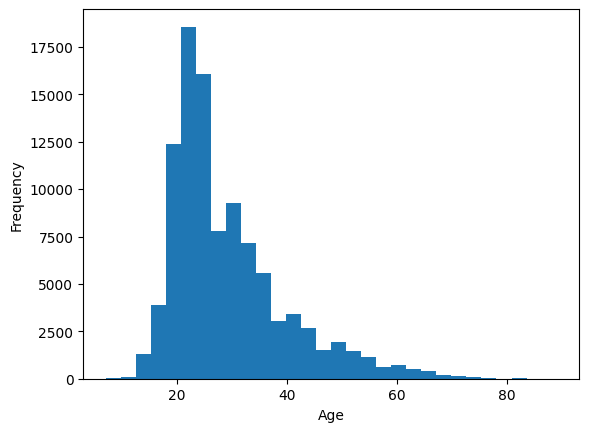

In [12]:
# Histogram of age of participants

df_lang['age'].plot.hist(xlabel='Age', bins=30)
df_lang['age'].describe()

,Eng_start
count,55079.000000
mean,8.620527
std,3.698787
min,0.000000
25%,7.000000
50%,9.000000
75%,10.000000
max,69.000000


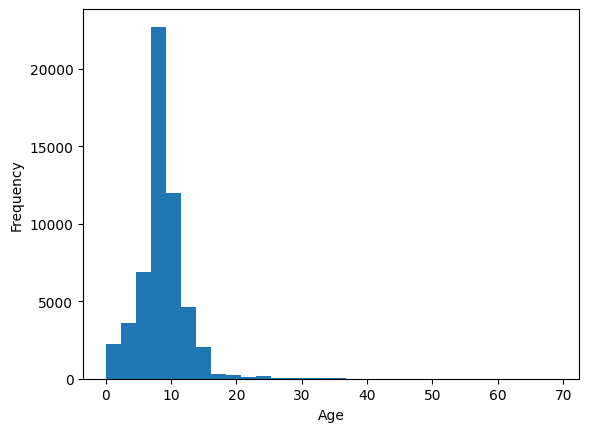

In [13]:
# Histogram of first English exposure for non-native speakers

df_lang_nonnat = df_lang[df_lang['nat_Eng'] == 0]
df_lang_nonnat['Eng_start'].plot.hist(bins=30, xlabel='Age')
df_lang_nonnat['Eng_start'].describe()

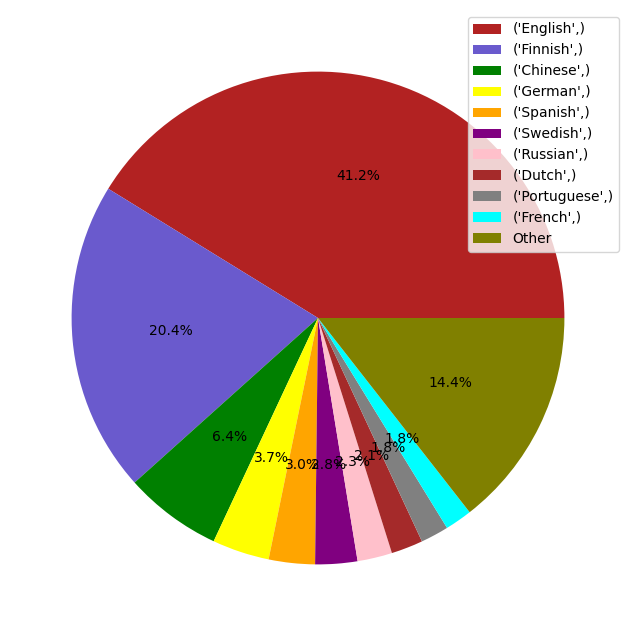

In [14]:
# Pie chart showing the percentages of non-native English speakers in the dataset

df_natlang_other = pd.Series(df_ref_natlang.value_counts().iloc[10:].sum(), index=['Other'])
df_natlang_pie = pd.concat([df_ref_natlang.value_counts().iloc[0:10], df_natlang_other])

fig, ax = plt.subplots(figsize=(8, 8))
colors = ['firebrick', 'slateblue', 'green', 'yellow', 'orange', 'purple', 'pink', 'brown', 'gray', 'cyan', 'olive']

ax.pie(x=df_natlang_pie.values, labels=None, colors=colors, autopct='%1.1f%%')
plt.legend(df_natlang_pie.index, loc='best')
plt.show()

<Axes: xlabel='Eng_start', ylabel='Eng_country_yrs'>

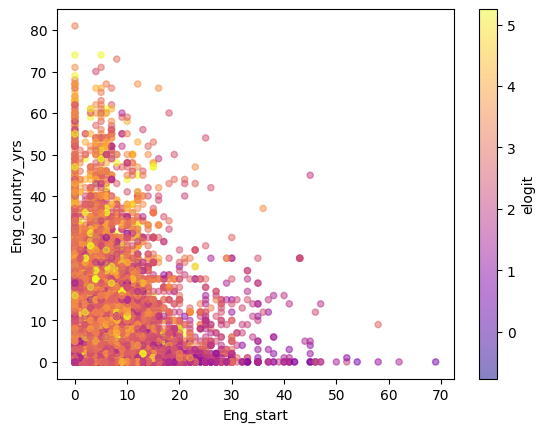

In [15]:
df_lang_tidy.plot.scatter(x='Eng_start',y='Eng_country_yrs',c='elogit',cmap='plasma',alpha=0.5)

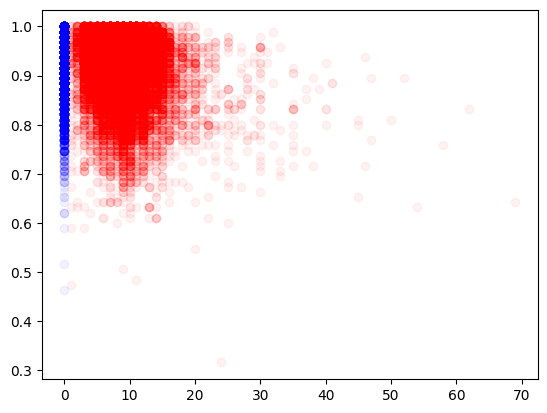

In [16]:
test2 = df_lang_tidy[df_lang_tidy['Eng_little'] == 'little'].groupby(['Eng_start'])['correct'].mean()

test3 = df_lang_tidy[df_lang_tidy['Eng_little'] == 'little']#[df_lang_tidy['Eng_start'] >= 17]
test4 = df_lang_tidy[df_lang_tidy['Eng_little'] == 'monoeng']

plt.scatter(test3['Eng_start'],test3['correct'], c='red',alpha=0.05)
plt.scatter(test4['Eng_start'],test4['correct'], c='blue',alpha=0.05)

### Conclusion

From these light analyses, we have a better understanding of the demographics of the participants included, and we began to show what relationships might exist between demographic characteristics and English proficiency. We are interested in grouping by native language along with other variables to see if patterns emerge in the scores and types of questions.

# Milestone 2

For the second milestone, we included and parsed an additional relevant dataset.

Specifically, we pulled the following dataset from the World Atlas of Language Structures Online (WALS) webpage, which has a number of datasets on structural features of various languages. The questions in the English proficiency test from the first dataset were not explicitly testing specific elements of syntactic knowledge, so we selected fifteen grammatical features that seemed relevant to the test questions.

Using these features, we hope to create rough groupings of languages based on structural similarity rather than geographic similarity and assess each grouping's performance on the test questions.

In [17]:
# Change to folder containing all additional CSVs:
%cd /content/drive/MyDrive/ColabNotebooks/additionalFiles

import glob

# Glob all csv files:
all_csvs = glob.glob('*.csv')

# Create base df for later merging:
df_features = pd.read_csv('future_tense.csv',sep='\t').drop(columns = ['description','value'])

# Iterate through list and merge dfs:
for file in all_csvs:
  # Read in current file and slice for non-redundant columns:
  df_current = pd.read_csv(file,sep='\t')
  df_current = df_current[['name','value','description']]
  current_name = file[:-4] # Get name of file for df columns

  df_current = df_current.rename(columns={'name':'name','value':current_name+'_value','description':current_name+'_description'})
  df_features = df_features.merge(df_current, on='name',how='outer')

# Drop unnecessary variables
df_features.drop(columns=['wals code', 'latitude', 'longitude', 'area'])

/content/drive/MyDrive/ColabNotebooks/additionalFiles


,name,genus,family,case_num_value,case_num_description,perfective_aspect_value,perfective_aspect_description,future_tense_value,future_tense_description,indef_art_value,...,syllable_value,syllable_description,perfect_value,perfect_description,neg_morpheme_value,neg_morpheme_description,polar_q_value,polar_q_description,def_art_value,def_art_description
0,!Xóõ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,Moderately complex,NaN,NaN,NaN,NaN,1.0,Question particle,NaN,NaN
1,//Ani,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,Moderately complex,NaN,NaN,2.0,Negative particle,1.0,Question particle,NaN,NaN
2,/Xam,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,Negative particle,NaN,NaN,NaN,NaN
3,=|Hoan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Question particle,NaN,NaN
4,Aari,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,1.0,Negative affix,2.0,Interrogative verb morphology,3.0,Definite affix
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1820,Zulu,Bantu,Niger-Congo,1.0,No morphological case-marking,1.0,Grammatical marking,1.0,Inflectional future exists,5.0,...,2.0,Moderately complex,3.0,Other perfect,1.0,Negative affix,1.0,Question particle,5.0,No definite or indefinite article
1821,Zuni,Zuni,Zuni,1.0,No morphological case-marking,2.0,No grammatical marking,2.0,No inflectional future,NaN,...,2.0,Moderately complex,4.0,No perfect,6.0,Double negation,NaN,NaN,NaN,NaN
1822,rGyalrong (Caodeng),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,Negative affix,NaN,NaN,NaN,NaN
1823,Émérillon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,6.0,Double negation,1.0,Question particle,NaN,NaN


In [18]:
# Check for differences between Mandarin and Cantonese
mandarin = df_features[df_features['name'] == 'Mandarin'].reset_index(drop=True)
cantonese = df_features[df_features['name'] == 'Cantonese'].reset_index(drop=True)
mandarin.compare(cantonese)

# Combine Mandarin and Cantonese into a single observation, Chinese
df_features.loc[df_features['name'] == 'Mandarin', 'name'] = 'Chinese'
df_features.loc[df_features['name'] == 'Cantonese', 'name'] = 'Chinese'
df_features = df_features.groupby('name').first().reset_index()

# Rename other languages with inconsistent names between datasets
df_features['name'] = df_features['name'].str.replace(r'^Malay.*', 'Malay', regex=True)
df_features['name'] = df_features['name'].str.replace(r'^Greek.*', 'Greek', regex=True)
df_features['name'] = df_features['name'].str.replace(r'^Serbian.*', 'Serbian', regex=True)

Because in the WALS dataset (and not the original dataset), Arabic is broken up by regional dialect, and each dialect is significantly different grammatically, we have to drop it:

In [19]:
df_features.drop(df_features[df_features['name'] == 'Arabic'].index, inplace=True)
df_lang_tidy.drop(df_lang_tidy[df_lang_tidy['natlang'] == 'Arabic'].index, inplace=True)

We then merge the new DataFrame with the DataFrame from the previous milestone:

In [20]:
# Merge df_features with df_lang_tidy on natlang
df_features = df_features.rename(columns={'name':'natlang'})
df_lang_tidy = df_lang_tidy.merge(df_features, how='left', on='natlang')

We were interested in the distribution of language families in the dataset:

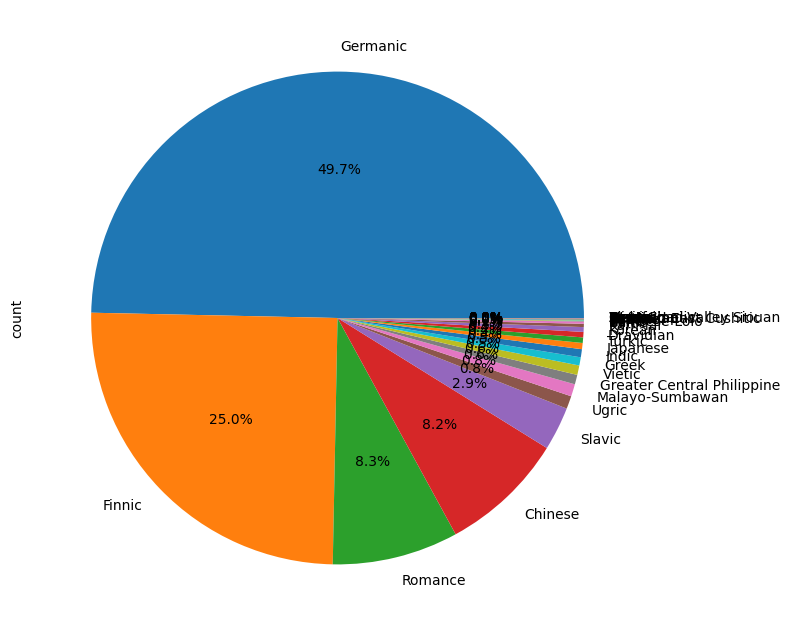

In [21]:
genus_pie = df_lang_tidy['genus'].value_counts().plot.pie(figsize=(8,8), autopct='%1.1f%%')

What are the distributions of particular languages within each language family represented here?

In [22]:
df_lang_tidy.groupby('genus')['natlang'].value_counts()

genus                       natlang   
Ainu                        Ainu             10
Baltic                      Latvian         190
Bantu                       Swahili          39
                            Zulu              8
Barito                      Malagasy          2
Basque                      Basque           45
Burmese-Lolo                Burmese          47
Chinese                     Chinese       10782
Defoid                      Yoruba           20
Dravidian                   Tamil           377
                            Kannada          89
Finnic                      Finnish       32914
Germanic                    English       53674
                            German         6050
                            Swedish        5079
                            Afrikaans       254
                            Icelandic       239
Greater Central Philippine  Tagalog         786
                            Cebuano          37
Greek                       Greek           705
Indic                       Hindi           440
                            Bengali         257
Japanese                    Japanese        532
Kam-Tai                     Thai            268
                            Lao              11
Kartvelian                  Georgian         24
Khmer                       Khmer            23
Korean                      Korean          412
Lowland East Cushitic       Somali           24
Malayo-Sumbawan             Indonesian     1065
Mississippi Valley Siouan   Lakhota           5
Oceanic                     Maori             7
                            Hawaiian          2
Romance                     Spanish        4943
                            French         2948
                            Portuguese     2453
                            Romanian        522
Semitic                     Maltese          46
Slavic                      Russian        3435
                            Bulgarian       319
Turkic                      Turkish         475
Ugric                       Hungarian      1113
Vietic                      Vietnamese      817
West Chadic                 Hausa             1
Wolof                       Wolof             2
Name: count, dtype: int64

We then computed a distance matrix to determine which languages were grammatically closest to English based on these features.

In [23]:
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer

# For visualization, filter by the top 30 most common languages in the dataset
df_lang_tidy_30_index = df_lang_tidy['natlang'].value_counts()[:30].index
df_features = df_features[df_features['natlang'].isin(df_lang_tidy_30_index)]

# Replace NaN values with a dummy value
# We hope to do a more complex imputation in the future
df_features_desc = df_features.filter(regex='_description$').fillna('blank')

# Prepare for vectorizing
df_features_dict = df_features_desc.to_dict(orient="records")
vec = DictVectorizer(sparse=False)
vec.fit(df_features_dict)

df_features_encode = vec.transform(df_features_dict)

# Standardize data
scaler = StandardScaler()
scaler.fit(df_features_encode)
df_features_sc = scaler.transform(df_features_encode)

D = pairwise_distances(df_features_encode, metric='euclidean')
np.fill_diagonal(D, np.nan)
df_features_sc = pd.DataFrame(D, index=df_features['natlang'], columns=df_features['natlang'])
display(df_features_sc)

natlang,Catalan,Chinese,Czech,Danish,Dutch,English,Estonian,Finnish,French,German,...,Portuguese,Romanian,Russian,Serbian,Slovak,Spanish,Swedish,Tagalog,Turkish,Vietnamese
natlang,,,,,,,,,,,,,,,,,,,,,
Catalan,NaN,4.472136,4.000000,3.741657,3.741657,4.898979,3.741657,4.898979,4.472136,4.898979,...,4.472136,4.000000,4.690416,3.464102,4.000000,4.242641,4.242641,4.472136,4.690416,4.898979
Chinese,4.472136,NaN,5.291503,4.898979,5.099020,4.690416,4.898979,4.472136,4.242641,4.690416,...,4.000000,4.242641,4.242641,4.898979,5.477226,4.242641,4.690416,4.242641,4.472136,3.162278
Czech,4.000000,5.291503,NaN,2.828427,3.162278,4.898979,2.449490,4.690416,5.291503,5.099020,...,4.242641,4.690416,4.898979,2.828427,3.162278,4.898979,4.242641,5.291503,5.291503,5.291503
Danish,3.741657,4.898979,2.828427,NaN,2.828427,4.690416,3.162278,5.291503,5.099020,5.099020,...,3.741657,4.000000,5.099020,3.162278,3.464102,4.898979,3.741657,5.291503,5.477226,5.099020
Dutch,3.741657,5.099020,3.162278,2.828427,NaN,4.472136,3.162278,5.291503,4.898979,4.472136,...,4.242641,4.690416,5.291503,3.464102,3.464102,4.472136,4.242641,4.898979,5.477226,5.099020
English,4.898979,4.690416,4.898979,4.690416,4.472136,NaN,4.898979,4.000000,4.000000,2.449490,...,4.472136,4.242641,4.000000,5.099020,5.291503,3.741657,3.741657,4.690416,5.099020,4.690416
Estonian,3.741657,4.898979,2.449490,3.162278,3.162278,4.898979,NaN,4.242641,4.898979,5.099020,...,4.000000,4.472136,4.472136,2.000000,3.464102,4.898979,4.242641,4.898979,5.291503,5.099020
Finnish,4.898979,4.472136,4.690416,5.291503,5.291503,4.000000,4.242641,NaN,4.472136,4.242641,...,4.690416,4.690416,4.000000,4.690416,5.291503,4.242641,4.690416,4.242641,4.472136,4.242641
French,4.472136,4.242641,5.291503,5.099020,4.898979,4.000000,4.898979,4.472136,NaN,4.000000,...,4.000000,4.242641,3.741657,4.898979,5.477226,2.449490,4.472136,4.000000,4.000000,4.690416


<Axes: xlabel='natlang', ylabel='natlang'>

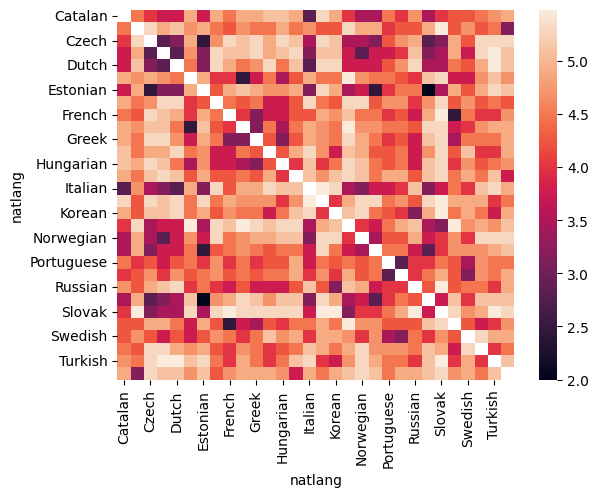

In [24]:
# create a visualization for the distance matrix
import seaborn as sns
sns.heatmap(df_features_sc)

We then calculated each language's distance from English based on the syntactic features. While there were some surprising languages, due to our including only a small number of grammatical features, the distances lined up with our intuitions well overall.

In [25]:
# Slice DataFrame for distances from English
df_eng_dist = df_features_sc['English'].sort_values()

df_eng_dist

,English
natlang,
German,2.449490
Hungarian,3.464102
Swedish,3.741657
Spanish,3.741657
Greek,3.741657
Russian,4.000000
Finnish,4.000000
French,4.000000
Romanian,4.242641


<Axes: xlabel='Distance', ylabel='correct'>

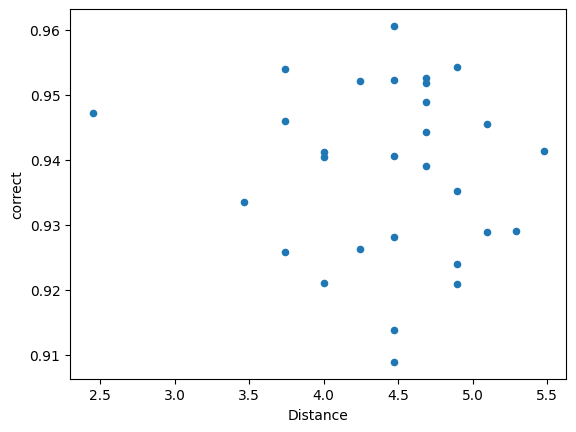

In [26]:
# Slice dataset for top 30 languages
df_lang_tidy_30 = df_lang_tidy[df_lang_tidy['natlang'].isin(df_lang_tidy_30_index)]
df_30_correct = df_lang_tidy_30.groupby('natlang')['correct'].mean().sort_values(ascending=False)

# Organize alphabetically to have the same index
df_eng_dist = df_eng_dist.sort_index()
df_30_correct = df_30_correct.sort_index()

# Concatenate the two Series and sort
df_eng_dist_concat = pd.concat([df_eng_dist,df_30_correct],axis = 1)
df_eng_dist_concat = df_eng_dist_concat.rename(columns={'English': 'Distance'})
df_eng_dist_concat = df_eng_dist_concat.sort_values(by = 'Distance')

# Plot
df_eng_dist_concat.plot(x='Distance',y='correct',kind='scatter')

Unfortunately, but as expected, there does not appear to be a relationship between syntactic similarity to English and overall test performance when controlling for no other variables. Next, we determine whether groups of languages perform better than others using dimensionality reduction.

<Figure size 1000x800 with 0 Axes>

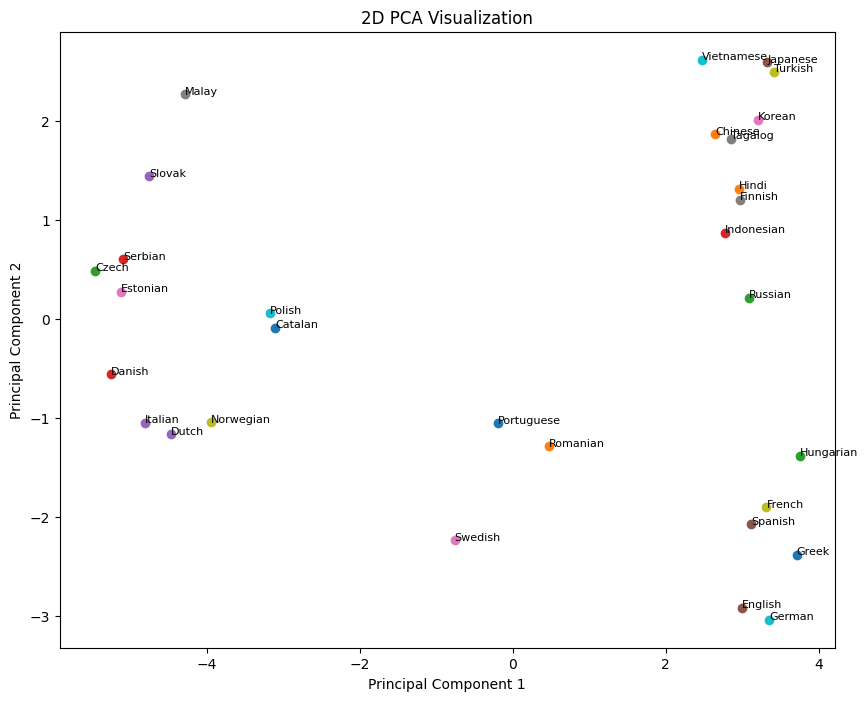

In [27]:
from sklearn.decomposition import PCA

plt.figure(figsize=(10, 8))

pca = PCA(n_components=2)

# Fit the PCA model to the scaled data
df_features_sc = df_features_sc.fillna(0)
principal_components = pca.fit_transform(df_features_sc)

# Create a DataFrame with the principal components
df_PCA = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Plot results
plt.figure(figsize=(10, 8))  # Adjust figure size if needed

# Scatter plot with labels
for i, language in enumerate(df_features['natlang']):
    x = df_PCA.loc[i, 'PC1']
    y = df_PCA.loc[i, 'PC2']
    plt.scatter(x, y)
    plt.text(x, y, language, fontsize=8)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA Visualization')
plt.show()

We also generated a PCA biplot to determine which grammatical features have the greatest weight on each PC and how correlated features are to inform future analysis. More horizontal variable vectors weigh more heavily on PC1, whereas more vertical variable vectors weigh more heavily on PC2.

Note that the scale between this plot and the above plot is different.

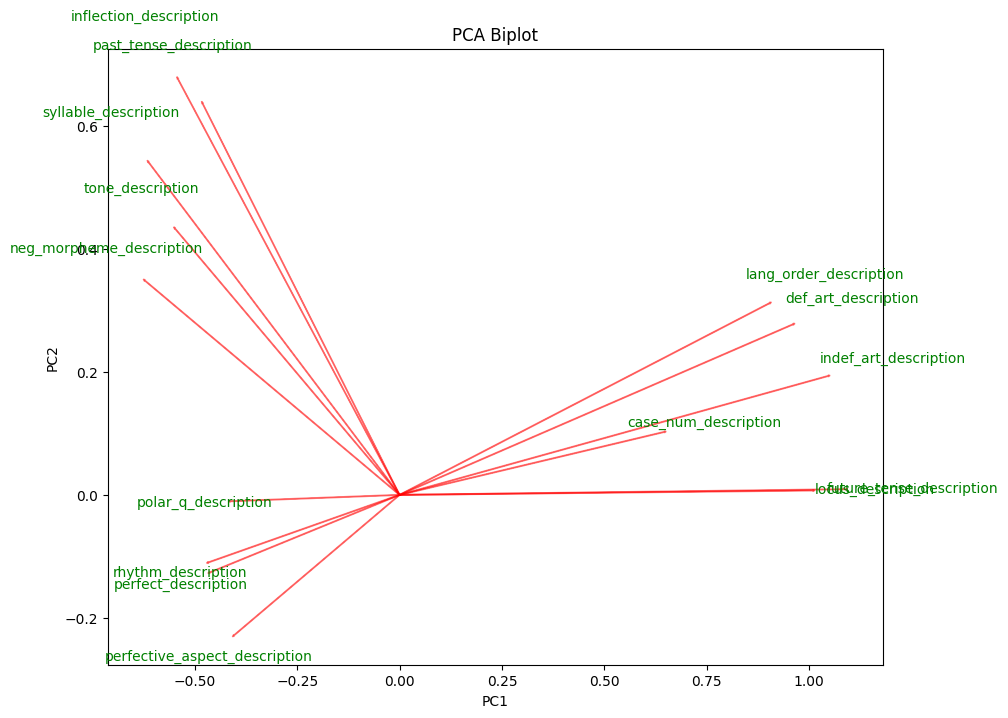

In [28]:
plt.figure(figsize=(10, 8))

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
for i, feature in enumerate(df_features_desc.columns):
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], color='r', alpha=0.5)
    plt.text(loadings[i, 0] * 1.15, loadings[i, 1] * 1.15, feature, color='g', ha='center', va='center')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Biplot')
plt.show()

While there are clearly some languages that are more similar than others, we decided to use K means clustering to be more certain of the groups of languages. We experimented with several different numbers of clusters, but decided on 7.

In [37]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7)

# Fit the model to the data
kmeans.fit(df_PCA)

# Get the cluster labels for each data point
labels = kmeans.labels_

# Add the labels to the dataframe
df_PCA['cluster'] = labels
df_PCA = df_PCA.set_index(df_features['natlang'])

df_PCA.sort_values(by='cluster')

,PC1,PC2,cluster
natlang,,,
Vietnamese,2.473934,2.620890,0
Chinese,2.644755,1.868199,0
Tagalog,2.853002,1.823404,0
Korean,3.208608,2.015829,0
Japanese,3.324785,2.597942,0
Turkish,3.413527,2.499742,0
Italian,-4.810940,-1.049030,1
Dutch,-4.468427,-1.164111,1
Estonian,-5.124868,0.276648,1


At first glance, we only saw slight differences in performance by cluster:

In [38]:
df_lang_tidy_new = df_lang_tidy.merge(df_PCA, on='natlang', how = 'left')
df_lang_tidy_new.groupby('cluster')['correct'].mean()

,correct
cluster,
0.0,0.942390
1.0,0.945859
2.0,0.939059
3.0,0.940144
4.0,0.958559
5.0,0.935708


Here, we create a graph showing the performance on each question for each cluster.

In [31]:
# Create index of each question column
question_index = df_lang_tidy_new.columns[pd.Series(df_lang_tidy_new.columns).str.startswith('q')]

# Create empty list
df_questions = pd.DataFrame()

# Iterate through questions to find correct % for each question based on clusters
for question in question_index:
  clust = df_lang_tidy_new.groupby('cluster')[question].mean() # change the var name if you like
  df_questions = pd.concat([df_questions, clust],axis=1)

<Axes: >

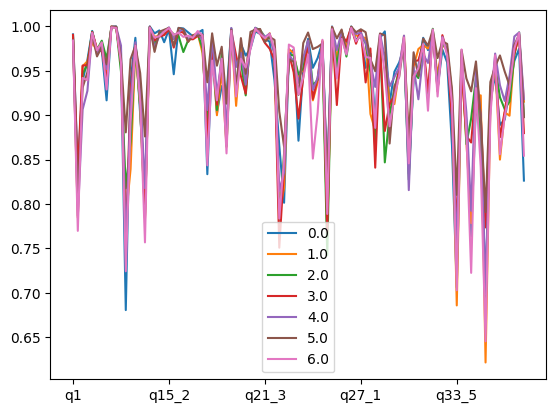

In [32]:
df_questions.transpose().plot()

Since the graph above is difficult to interpret, we take the standard deviation of each question to find questions with highest spread so that we can identify questions that may best distinguish speakers of different languages.

,0
q34_1,0.076228
q11_4,0.065133
q34_4,0.062604
q28_2,0.056213
q22_2,0.053703
...,...
q25_3,0.001000
q13_4,0.000857
q10_4,0.000656
q26_3,0.000523


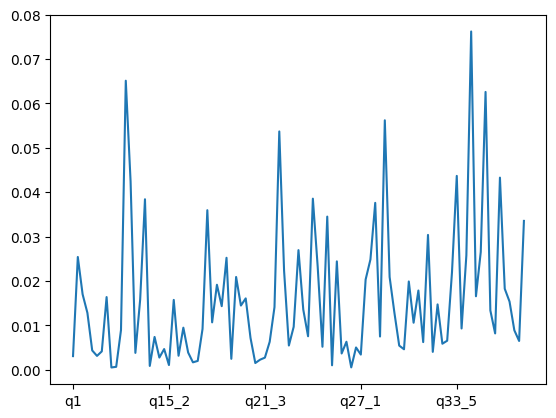

In [33]:

# so that hopefully there are connections between the most different results
df_questions_std = df_questions.std() # operate on columns
df_questions_std.plot()
df_questions_std.sort_values(ascending=False)
#34_1, 11_4, 34_4 are the most different?

**Conclusion**

In this milestone, we have imported a new dataset containing additional information on structural features of the languages in the original dataset. We then assessed the performance of each language relative to English. Moving forward, we aim to use a regression model to predict a given speaker's performance on the English profiency test or use a classifier to predict whether a given speaker began learning English before or after 17 years old, which was the critical age stated in Hartshorne, J.K. et al, 2018. We also plan to explore and control for several relevant variables, such as education level, age, and country of residence.